In [1]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter as fsf
from matplotlib.gridspec import GridSpec
from plots.mpltoolkit import named_colors, mpl_loc, fancy_legend, load_mpl_presets, append_axes, markers
import vice
from vice.yields.presets import JW20
import numpy as np
import math as m
import sys
sys.path.append("..")
from utils import exponential
load_mpl_presets()
print(sys.version_info)

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=8, micro=8, releaselevel='final', serial=0)


In [2]:
raw = np.genfromtxt("../data/gsechem.dat")
data = {}
data["[fe/h]"] = raw[:, 0]
data["[fe/h]_err"] = raw[:, 1]
data["[o/fe]"] = raw[:, 2]
data["[o/fe]_err"] = raw[:, 3]

Median [Fe/H] error: 0.0585
Median [O/Fe] error: 0.0567


/Users/astrobeard/Work/Research/VICErepos/VICE/vice/core/pickles.py:310: UserWarning: Encoding functions along with VICE outputs requires the package dill (installable via pip). The following attribute will not be saved with this output: func
  warnings.warn("""\


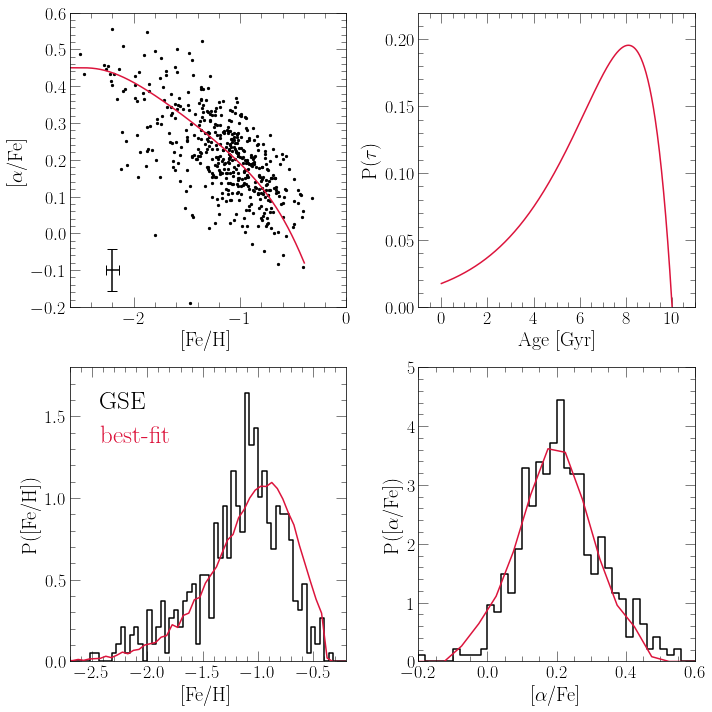

In [4]:
fig = plt.figure(figsize = (10, 10))
axes = 2 * [None]
for i in range(len(axes)):
    axes[i] = 2 * [None]
    for j in range(len(axes[i])):
        axes[i][j] = fig.add_subplot(221 + 2 * i + j)

axes[0][0].set_xlabel("[Fe/H]")
axes[0][0].set_ylabel(r"[$\alpha$/Fe]")
axes[0][0].set_xlim([-2.6, 0])
axes[0][0].set_ylim([-0.2, 0.6])

med_ofe_err = np.median(data["[o/fe]_err"])
med_feh_err = np.median(data["[fe/h]_err"])
print("Median [Fe/H] error: %.4f" % (med_feh_err))
print("Median [O/Fe] error: %.4f" % (med_ofe_err))
kwargs = {
    "c": named_colors()["black"],
    "xerr": med_feh_err,
    "yerr": med_ofe_err,
    "linestyle": "None"
}
axes[0][0].errorbar(-2.2, -0.1, **kwargs)
del kwargs["xerr"]
del kwargs["yerr"]
del kwargs["linestyle"]
kwargs["s"] = 5
axes[0][0].scatter(data["[fe/h]"], data["[o/fe]"], **kwargs)

with vice.singlezone(name = "bestfit") as sz:
    sz.func = exponential(timescale = 2.45)
    sz.mode = "ifr"
    sz.Mg0 = 0
    sz.nthreads = 2
    sz.tau_star = 23.86
    sz.eta = 15.25
    out = sz.run(np.linspace(0, 10, 1001), overwrite = True, capture = True)
    axes[0][0].plot(out.history["[fe/h]"], out.history["[o/fe]"],
        c = named_colors()["crimson"])
    
axes[0][1].set_xlabel("Age [Gyr]")
axes[0][1].set_ylabel(r"P($\tau$)")
axes[0][1].set_xlim([-1, 11])
axes[0][1].set_xticks([0, 2, 4, 6, 8, 10])
axes[0][1].set_ylim([0, 0.22])
dt = out.history["time"][1] - out.history["time"][0]
norm = sum(out.history["sfr"]) * dt
agedist = [_ / norm for _ in out.history["sfr"]]
axes[0][1].plot(out.history["lookback"], agedist, c = named_colors()["crimson"])

axes[1][0].set_xlabel("[Fe/H]")
axes[1][0].set_ylabel("P([Fe/H])")
axes[1][0].set_xlim([-2.7, -0.2])
axes[1][0].set_ylim([0, 1.8])
axes[1][0].set_yticks([0, 0.5, 1.0, 1.5])
hist, bins = np.histogram(data["[fe/h]"], bins = 100, range = [-3, 1], density = True)
axes[1][0].step(bins[:-1], hist, where = "post", c = named_colors()["black"],
    label = "GSE")
xvals = [(a + b) / 2 for a, b in zip(out.mdf["bin_edge_left"], out.mdf["bin_edge_right"])]
axes[1][0].plot(xvals, out.mdf["dn/d[fe/h]"], c = named_colors()["crimson"],
    label = "best-fit")

kwargs = {
    "loc": mpl_loc("upper left"),
    "ncol": 1,
    "handlelength": 0,
    "fontsize": 25
}
leg = axes[1][0].legend(**kwargs)
fancy_legend(leg, ["black", "crimson"])

axes[1][1].set_xlabel(r"[$\alpha$/Fe]")
axes[1][1].set_ylabel(r"P([$\alpha$/Fe])")
axes[1][1].set_xlim([-0.2, 0.6])
axes[1][1].set_ylim([0, 5])
hist, bins = np.histogram(data["[o/fe]"], bins = 100, range = [-1, 1], density = True)
axes[1][1].step(bins[:-1], hist, where = "post", c = named_colors()["black"])
axes[1][1].plot(xvals, out.mdf["dn/d[o/fe]"], c = named_colors()["crimson"])

plt.tight_layout()
for ext in ["pdf", "jpeg"]: plt.savefig("./GSE_distributions.%s" % (ext))
plt.show()